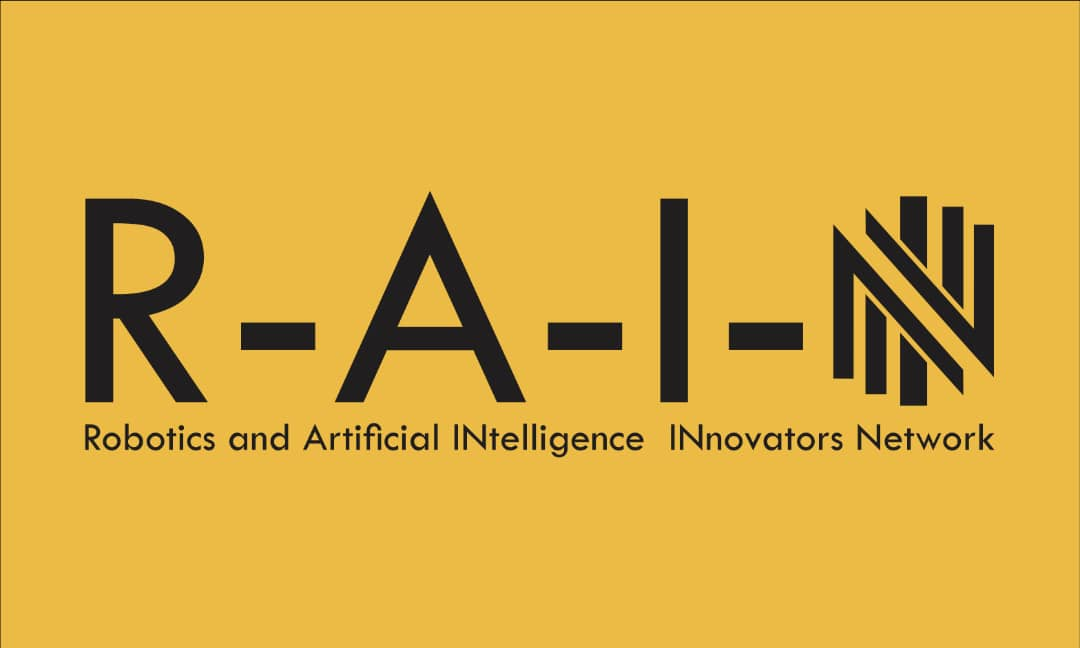

In [82]:
!git checkout master

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!mkdir data

In [16]:
!pwd

/content


In [ ]:
!mkdir logs

In [ ]:
!mkdir imageclassifier

1. **Install Dependencies and Setup**

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [20]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [22]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
import tensorflow as tf
import os

In [23]:
os.listdir('data')

['benign', '.ipynb_checkpoints', 'malignant']

In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**2. Remove dodgy images**

In [25]:
import cv2
import imghdr

In [26]:
data_dir = 'data'

In [27]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [28]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Image not in ext list data/benign/Untitled-design.webp
Image not in ext list data/benign/-Tumor-X-Differences-To-Know_1200x630_copy-554052943c11420e91a64cfdc3757881.webp
Image not in ext list data/malignant/BreastCancerEarlySigns-Symptoms-Types-RiskFactorsandPrevention-640w.jpg
Image not in ext list data/malignant/Earlysigns-symptomsofbreastcancer-640w.jpg
Image not in ext list data/malignant/3D20mammography20tomosythesis20example_Hologic202.jpg.webp


**3. Load Data**

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import numpy as np
from matplotlib import pyplot as plt

In [31]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 256 files belonging to 2 classes.


In [41]:
data_iterator = data.as_numpy_iterator()

In [42]:
batch = data_iterator.next()

In [43]:
len(batch)

2

In [44]:
batch[1]

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

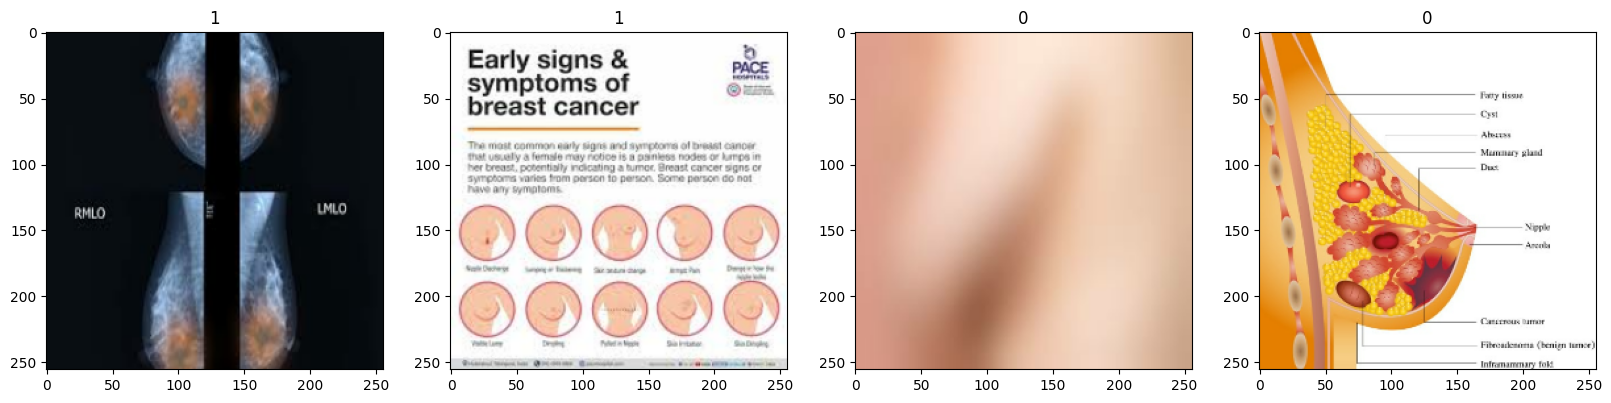

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**4. Scale Data**

In [46]:
data = data.map(lambda x,y: (x/255, y))

In [47]:
data.as_numpy_iterator().next()

(array([[[[0.46666667, 0.52156866, 0.5254902 ],
          [0.46855086, 0.5234528 , 0.5273744 ],
          [0.47607997, 0.5309819 , 0.53490347],
          ...,
          [0.20941329, 0.26431525, 0.26431525],
          [0.20486367, 0.25976562, 0.25976562],
          [0.20752911, 0.26243106, 0.26243106]],
 
         [[0.46682245, 0.52172446, 0.52564603],
          [0.47002897, 0.52493095, 0.5288525 ],
          [0.47607997, 0.5309819 , 0.53490347],
          ...,
          [0.20941329, 0.26431525, 0.26431525],
          [0.20634176, 0.26124373, 0.26124373],
          [0.20947458, 0.26437652, 0.26437652]],
 
         [[0.46760875, 0.5225107 , 0.5264323 ],
          [0.4721584 , 0.52706033, 0.5309819 ],
          [0.47670802, 0.53161   , 0.5355316 ],
          ...,
          [0.21066943, 0.2655714 , 0.2655714 ],
          [0.20862208, 0.26352406, 0.26352406],
          [0.21207874, 0.2669807 , 0.2669807 ]],
 
         ...,
 
         [[0.63289243, 0.66818655, 0.70348066],
          [0.63607

**5. Split Data**

In [48]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [49]:
train_size

5

In [50]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

**6. Build Deep Learning Model**

In [51]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [53]:
model = Sequential()

In [54]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

**7. Train**

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:

  hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/20
5/5 [==============================] - 9s 504ms/step - loss: 1.7764 - accuracy: 0.4500 - val_loss: 0.7467 - val_accuracy: 0.5625
Epoch 2/20
5/5 [==============================] - 5s 749ms/step - loss: 0.7307 - accuracy: 0.4938 - val_loss: 0.7728 - val_accuracy: 0.2812
Epoch 3/20
5/5 [==============================] - 2s 237ms/step - loss: 0.6852 - accuracy: 0.5437 - val_loss: 0.6975 - val_accuracy: 0.5312
Epoch 4/20
5/5 [==============================] - 2s 228ms/step - loss: 0.6820 - accuracy: 0.5813 - val_loss: 0.6806 - val_accuracy: 0.5625
Epoch 5/20
5/5 [==============================] - 2s 228ms/step - loss: 0.6857 - accuracy: 0.5375 - val_loss: 0.6679 - val_accuracy: 0.6250
Epoch 6/20
5/5 [==============================] - 2s 354ms/step - loss: 0.6764 - accuracy: 0.6062 - val_loss: 0.6604 - val_accuracy: 0.5625
Epoch 7/20
5/5 [==============================] - 2s 262ms/step - loss: 0.6627 - accuracy: 0.5562 - val_loss: 0.6580 - val_accuracy: 0.6250
Epoch 8/20
5/5 [====

In [60]:
hist.history

{'loss': [1.7764256000518799,
  0.7306506633758545,
  0.6851984858512878,
  0.6820468306541443,
  0.6857296824455261,
  0.6763827204704285,
  0.6626695990562439,
  0.642707884311676,
  0.6454668045043945,
  0.6031255125999451,
  0.5702147483825684,
  0.5651422739028931,
  0.5710102319717407,
  0.5287252068519592,
  0.4393691122531891,
  0.4850543141365051,
  0.43957608938217163,
  0.39800405502319336,
  0.36564162373542786,
  0.3328842520713806],
 'accuracy': [0.44999998807907104,
  0.4937500059604645,
  0.543749988079071,
  0.581250011920929,
  0.5375000238418579,
  0.606249988079071,
  0.5562499761581421,
  0.637499988079071,
  0.6312500238418579,
  0.7124999761581421,
  0.71875,
  0.6875,
  0.668749988079071,
  0.762499988079071,
  0.8187500238418579,
  0.7124999761581421,
  0.7875000238418579,
  0.824999988079071,
  0.800000011920929,
  0.8500000238418579],
 'val_loss': [0.7467447519302368,
  0.7727944850921631,
  0.697494387626648,
  0.6805949807167053,
  0.6679058074951172,
  0.6

**8. Plot Performance**

In [61]:
import numpy as np
from matplotlib import pyplot as plt

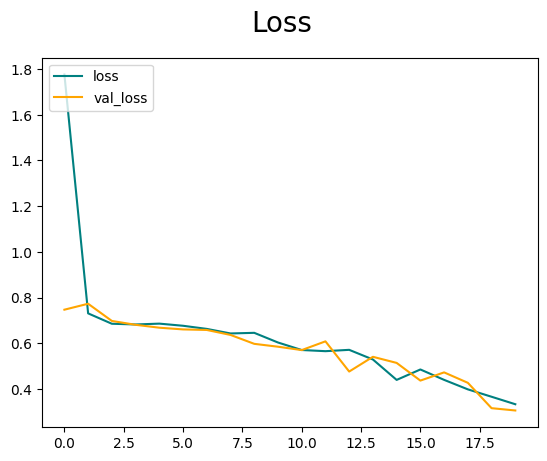

In [62]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

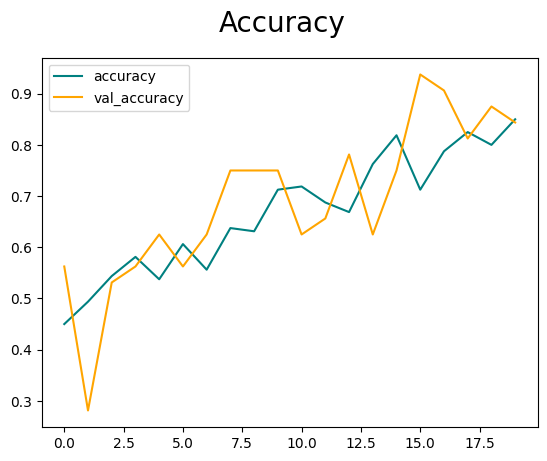

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. **Evaluate**

In [64]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [65]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [66]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [67]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


**10. Test**

In [68]:
import cv2

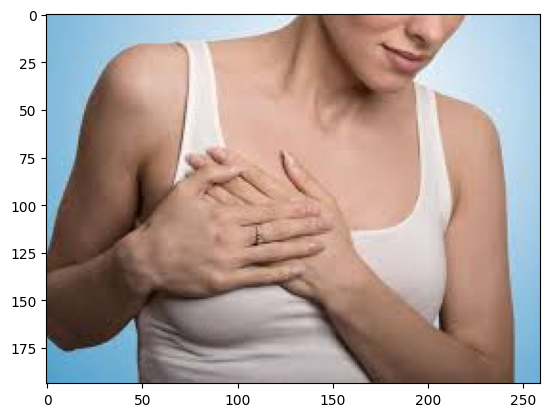

In [70]:
img = cv2.imread('malignantTest.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

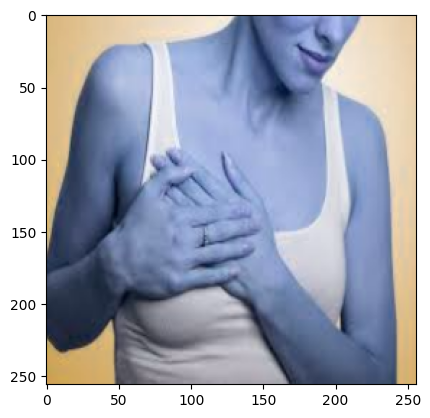

In [71]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [72]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 271ms/step


In [73]:
yhat

array([[0.24131493]], dtype=float32)

In [75]:
if yhat > 0.5:
    print(f'Predicted class is benign')
else:
    print(f'Predicted cancer is malignant, you can reach out to doctors for more diagnosis')

Predicted cancer is malignant, you can reach out to doctors for more diagnosis


**11. Save the Mode**l

In [76]:
from tensorflow.keras.models import load_model

In [77]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
new_model = load_model('/content/models/imageclassifier.h5')